In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
### === IMPORTS FOR SIM === ###

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d


from doa_sim_methods import run_spacing_vs_frequency_sweep
from doa_sim_methods import run_spacing_vs_frequency_sweep_aim
from doa_sim_methods import plot_2d_heatmap
from doa_sim_methods import plot_recordings

from processing_methods import estimate_doa_from_recordings
from processing_methods import estimate_doa_using_aim
from microphone_objects import microphoneArray
from source_objects import fileSource, pureTone, sweepSource

In [107]:
### === VARIABLE SETUP === ###

sample_rate = 44100
frequencies = np.arange(100, 20001, 500)  # Frequencies from 100 Hz to 20000 Hz
spacings = np.arange(0.01, 0.21, 0.01)  # Spacings from 0.01 m to 0.20 m
angle_range = np.arange(-180, 181, 18)  # Angle range in degrees


In [91]:
def run_frequency_spacing_grid_simulation(
    sample_rate=44100,
    frequencies=np.linspace(100, 2000, 20),
    spacings=np.linspace(0.01, 0.2, 20),
    angle_range=np.linspace(-180, 180, 36),
    parameter_sets=None,
    vmin=0,
    vmax=180,
    figsize=(16, 20)
):
    """
    Run frequency vs spacing simulations for multiple parameter sets and display as grid of heatmaps.
    
    Parameters:
    -----------
    sample_rate : int
        Sample rate for audio simulation
    frequencies : array-like
        Frequency values to test (Hz)
    spacings : array-like
        Microphone spacing values to test (meters)
    angle_range : array-like
        Range of angles to test for each frequency/spacing combination
    parameter_sets : list of dict
        List of parameter dictionaries. Each dict should contain:
        - 'mic_geometry': str ('planar', 'tetra')
        - 'noise': bool (True/False)
        - 'noise_amplitude': float
        - 'title': str (title for the subplot)
    vmin, vmax : float
        Color scale limits for heatmaps
    figsize : tuple
        Figure size for the grid plot
        
    Returns:
    --------
    results_dict : dict
        Dictionary containing results for each parameter set
    """
    
    # Default parameter sets if none provided
    if parameter_sets is None:
        parameter_sets = [
            {
                'mic_geometry': 'tetra',
                'noise': False,
                'noise_amplitude': 0.01,
                'title': 'Tetrahedral Array - No Noise'
            },
            {
                'mic_geometry': 'tetra',
                'noise': True,
                'noise_amplitude': 0.05,
                'title': 'Tetrahedral Array - With Noise'
            }
        ]
    
    # Calculate grid dimensions
    n_sets = len(parameter_sets)
    n_cols = min(2, n_sets)  # Maximum 2 columns
    n_rows = (n_sets + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure and subplots with shared colorbar space
    fig = plt.figure(figsize=figsize)
    
    # Create a GridSpec with space for colorbar
    gs = fig.add_gridspec(n_rows, n_cols + 1, 
                         width_ratios=[1]*n_cols + [0.05],  # Small space for colorbar
                         height_ratios=[1]*n_rows,
                         hspace=0.3, wspace=0.3)
    
    # Create subplot axes
    axes = []
    for i in range(n_rows):
        row_axes = []
        for j in range(n_cols):
            if i * n_cols + j < n_sets:
                ax = fig.add_subplot(gs[i, j])
                row_axes.append(ax)
        axes.append(row_axes)
    
    # Flatten axes for easier indexing
    axes_flat = [ax for row in axes for ax in row]
    
    # Store results for each parameter set
    results_dict = {}
    
    # Keep track of all images for shared colorbar
    images = []
    
    # Run simulation for each parameter set
    for i, params in enumerate(parameter_sets):
        print(f"\n=== Running simulation {i+1}/{n_sets}: {params['title']} ===")
        
        # Run the simulation
        results, freq_array, spacing_array = run_spacing_vs_frequency_sweep(
            sample_rate=sample_rate,
            frequencies=frequencies,
            spacings=spacings,
            angle_range=angle_range,
            mic_geometry=params['mic_geometry'],
            noise=params['noise'],
            noise_amplitude=params['noise_amplitude']
        )
        
        # Store results
        results_dict[params['title']] = {
            'results': results,
            'frequencies': freq_array,
            'spacings': spacing_array,
            'parameters': params
        }
        
        # Plot heatmap
        ax = axes_flat[i]
        
        # Clip results to color scale range
        results_clipped = np.clip(results, vmin, vmax)
        
        # Create heatmap
        im = ax.imshow(
            results_clipped,
            aspect='auto',
            cmap='viridis',
            origin='lower',
            extent=[spacing_array[0], spacing_array[-1], freq_array[0], freq_array[-1]],
            vmin=vmin,
            vmax=vmax
        )
        
        # Store image for shared colorbar
        images.append(im)
        
        # Set labels and title
        ax.set_xlabel('Microphone Spacing (m)', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frequency (Hz)', fontweight='bold', fontsize=12)
        ax.set_title(params['title'], fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3, color='white')
        
        # Make tick labels larger
        ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Add shared colorbar
    if images:  # Only add colorbar if we have images
        # Create colorbar axis
        cbar_ax = fig.add_subplot(gs[:, -1])
        
        # Create shared colorbar
        cbar = fig.colorbar(images[0], cax=cbar_ax, label='RMS Angle Error (°)')
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label('RMS Angle Error (°)', fontsize=13, fontweight='bold')
    
    # Add main title
    fig.suptitle('DOA Estimation Performance: Frequency vs Spacing Analysis', 
                 fontsize=18, fontweight='bold', y=0.95)
    
    plt.show()
    
    return results_dict

In [ ]:
parameter_sets = [
        
        {
            'mic_geometry': 'tetra',
            'noise': False,
            'noise_amplitude': 0.00,
            'title': 'Tetrahedral - Clean'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.001,
            'title': 'Tetrahedral - 40dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.0025,
            'title': 'Tetrahedral - 32dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.005,
            'title': 'Tetrahedral - 26dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.01,
            'title': 'Tetrahedral - 20dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.025,
            'title': 'Tetrahedral - 12dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.05,
            'title': 'Tetrahedral - 6dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.1,
            'title': 'Tetrahedral - 0dB SNR'
        }
    ]
    
    # Run the grid simulation
results = run_frequency_spacing_grid_simulation(
        sample_rate=sample_rate,
        frequencies=frequencies,
        spacings=spacings,
        angle_range=angle_range,
        parameter_sets=parameter_sets,
        vmin=0,
        vmax=45,  # Adjust based on your expected error range
        figsize=(16, 20)
)

In [ ]:
parameter_sets = [
        
        {
            'mic_geometry': 'planar',
            'noise': False,
            'noise_amplitude': 0.00,
            'title': 'Planar - Clean'
        },
        {
            'mic_geometry': 'planar',
            'noise': True,
            'noise_amplitude': 0.001,
            'title': 'Planar - 40dB SNR'
        },
        {
            'mic_geometry': 'planar',
            'noise': True,
            'noise_amplitude': 0.0025,
            'title': 'Planar - 32dB SNR'
        },
        {
            'mic_geometry': 'planar',
            'noise': True,
            'noise_amplitude': 0.005,
            'title': 'Planar - 26dB SNR'
        },
        {
            'mic_geometry': 'planar',
            'noise': True,
            'noise_amplitude': 0.01,
            'title': 'Planar - 20dB SNR'
        },
        {
            'mic_geometry': 'planar',
            'noise': True,
            'noise_amplitude': 0.025,
            'title': 'Planar - 12dB SNR'
        },
        {
            'mic_geometry': 'planar',
            'noise': True,
            'noise_amplitude': 0.05,
            'title': 'Planar - 6dB SNR'
        },
        {
            'mic_geometry': 'planar',
            'noise': True,
            'noise_amplitude': 0.1,
            'title': 'Planar - 0dB SNR'
        }
    ]
    
    # Run the grid simulation
results = run_frequency_spacing_grid_simulation(
        sample_rate=sample_rate,
        frequencies=frequencies,
        spacings=spacings,
        angle_range=angle_range,
        parameter_sets=parameter_sets,
        vmin=0,
        vmax=45,  # Adjust based on your expected error range
        figsize=(16, 20)
)

Running DOA simulation with varying microphone spacing and frequency...
Completed frequency 100 Hz (1/40)
Completed frequency 600 Hz (2/40)
Completed frequency 1100 Hz (3/40)
Completed frequency 1600 Hz (4/40)
Completed frequency 2100 Hz (5/40)
Completed frequency 2600 Hz (6/40)
Completed frequency 3100 Hz (7/40)
Completed frequency 3600 Hz (8/40)
Completed frequency 4100 Hz (9/40)
Completed frequency 4600 Hz (10/40)
Completed frequency 5100 Hz (11/40)
Completed frequency 5600 Hz (12/40)
Completed frequency 6100 Hz (13/40)
Completed frequency 6600 Hz (14/40)
Completed frequency 7100 Hz (15/40)
Completed frequency 7600 Hz (16/40)
Completed frequency 8100 Hz (17/40)
Completed frequency 8600 Hz (18/40)
Completed frequency 9100 Hz (19/40)
Completed frequency 9600 Hz (20/40)
Completed frequency 10100 Hz (21/40)
Completed frequency 10600 Hz (22/40)
Completed frequency 11100 Hz (23/40)
Completed frequency 11600 Hz (24/40)
Completed frequency 12100 Hz (25/40)
Completed frequency 12600 Hz (26/4

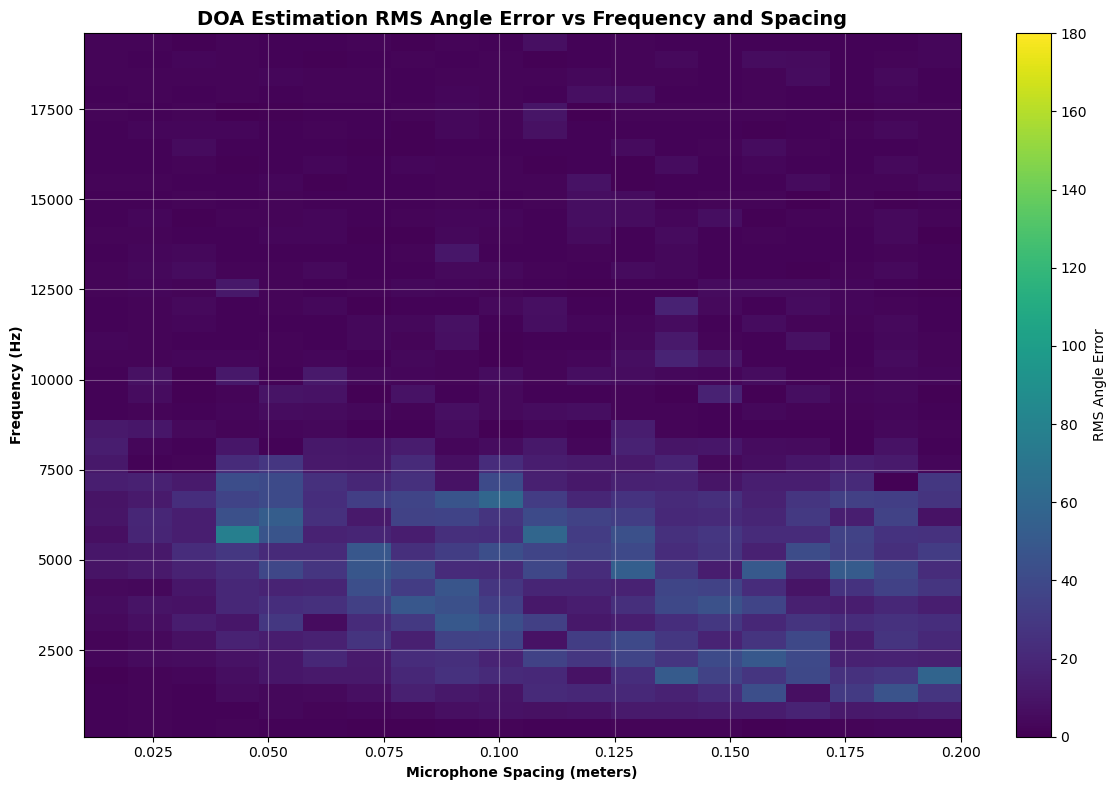

In [114]:
x, y, z = run_spacing_vs_frequency_sweep_aim(sample_rate=sample_rate, frequencies=frequencies, spacings=spacings, angle_range=angle_range, noise=False, noise_amplitude=0)
plot_2d_heatmap(x, y, z)

In [117]:
def run_frequency_spacing_grid_simulation_aim(
    sample_rate=44100,
    frequencies=np.linspace(100, 2000, 20),
    spacings=np.linspace(0.01, 0.2, 20),
    angle_range=np.linspace(-180, 180, 36),
    parameter_sets=None,
    vmin=0,
    vmax=180,
    figsize=(16, 20)
):
    """
    Run frequency vs spacing simulations for multiple parameter sets and display as grid of heatmaps.
    
    Parameters:
    -----------
    sample_rate : int
        Sample rate for audio simulation
    frequencies : array-like
        Frequency values to test (Hz)
    spacings : array-like
        Microphone spacing values to test (meters)
    angle_range : array-like
        Range of angles to test for each frequency/spacing combination
    parameter_sets : list of dict
        List of parameter dictionaries. Each dict should contain:
        - 'mic_geometry': str ('planar', 'tetra')
        - 'noise': bool (True/False)
        - 'noise_amplitude': float
        - 'title': str (title for the subplot)
    vmin, vmax : float
        Color scale limits for heatmaps
    figsize : tuple
        Figure size for the grid plot
        
    Returns:
    --------
    results_dict : dict
        Dictionary containing results for each parameter set
    """
    
    # Default parameter sets if none provided
    if parameter_sets is None:
        parameter_sets = [
            {
                'mic_geometry': 'tetra',
                'noise': False,
                'noise_amplitude': 0.01,
                'title': 'Tetrahedral Array - No Noise'
            },
            {
                'mic_geometry': 'tetra',
                'noise': True,
                'noise_amplitude': 0.05,
                'title': 'Tetrahedral Array - With Noise'
            }
        ]
    
    # Calculate grid dimensions
    n_sets = len(parameter_sets)
    n_cols = min(2, n_sets)  # Maximum 2 columns
    n_rows = (n_sets + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure and subplots with shared colorbar space
    fig = plt.figure(figsize=figsize)
    
    # Create a GridSpec with space for colorbar
    gs = fig.add_gridspec(n_rows, n_cols + 1, 
                         width_ratios=[1]*n_cols + [0.05],  # Small space for colorbar
                         height_ratios=[1]*n_rows,
                         hspace=0.3, wspace=0.3)
    
    # Create subplot axes
    axes = []
    for i in range(n_rows):
        row_axes = []
        for j in range(n_cols):
            if i * n_cols + j < n_sets:
                ax = fig.add_subplot(gs[i, j])
                row_axes.append(ax)
        axes.append(row_axes)
    
    # Flatten axes for easier indexing
    axes_flat = [ax for row in axes for ax in row]
    
    # Store results for each parameter set
    results_dict = {}
    
    # Keep track of all images for shared colorbar
    images = []
    
    # Run simulation for each parameter set
    for i, params in enumerate(parameter_sets):
        print(f"\n=== Running simulation {i+1}/{n_sets}: {params['title']} ===")
        
        # Run the simulation
        results, freq_array, spacing_array = run_spacing_vs_frequency_sweep_aim(
            sample_rate=sample_rate,
            frequencies=frequencies,
            spacings=spacings,
            angle_range=angle_range,
            noise=params['noise'],
            noise_amplitude=params['noise_amplitude']
        )
        
        # Store results
        results_dict[params['title']] = {
            'results': results,
            'frequencies': freq_array,
            'spacings': spacing_array,
            'parameters': params
        }
        
        # Plot heatmap
        ax = axes_flat[i]
        
        # Clip results to color scale range
        results_clipped = np.clip(results, vmin, vmax)
        
        # Create heatmap
        im = ax.imshow(
            results_clipped,
            aspect='auto',
            cmap='viridis',
            origin='lower',
            extent=[spacing_array[0], spacing_array[-1], freq_array[0], freq_array[-1]],
            vmin=vmin,
            vmax=vmax
        )
        
        # Store image for shared colorbar
        images.append(im)
        
        # Set labels and title
        ax.set_xlabel('Microphone Spacing (m)', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frequency (Hz)', fontweight='bold', fontsize=12)
        ax.set_title(params['title'], fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3, color='white')
        
        # Make tick labels larger
        ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Add shared colorbar
    if images:  # Only add colorbar if we have images
        # Create colorbar axis
        cbar_ax = fig.add_subplot(gs[:, -1])
        
        # Create shared colorbar
        cbar = fig.colorbar(images[0], cax=cbar_ax, label='RMS Angle Error (°)')
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label('RMS Angle Error (°)', fontsize=13, fontweight='bold')
    
    # Add main title
    fig.suptitle('DOA Estimation Performance: Frequency vs Spacing Analysis', 
                 fontsize=18, fontweight='bold', y=0.95)
    
    plt.show()
    
    return results_dict


=== Running simulation 1/8: Tetrahedral AIM - Clean ===
Running DOA simulation with varying microphone spacing and frequency...
Completed frequency 100 Hz (1/40)
Completed frequency 600 Hz (2/40)
Completed frequency 1100 Hz (3/40)
Completed frequency 1600 Hz (4/40)
Completed frequency 2100 Hz (5/40)
Completed frequency 2600 Hz (6/40)
Completed frequency 3100 Hz (7/40)
Completed frequency 3600 Hz (8/40)
Completed frequency 4100 Hz (9/40)
Completed frequency 4600 Hz (10/40)
Completed frequency 5100 Hz (11/40)
Completed frequency 5600 Hz (12/40)
Completed frequency 6100 Hz (13/40)
Completed frequency 6600 Hz (14/40)
Completed frequency 7100 Hz (15/40)
Completed frequency 7600 Hz (16/40)
Completed frequency 8100 Hz (17/40)
Completed frequency 8600 Hz (18/40)
Completed frequency 9100 Hz (19/40)
Completed frequency 9600 Hz (20/40)
Completed frequency 10100 Hz (21/40)
Completed frequency 10600 Hz (22/40)
Completed frequency 11100 Hz (23/40)
Completed frequency 11600 Hz (24/40)
Completed freq

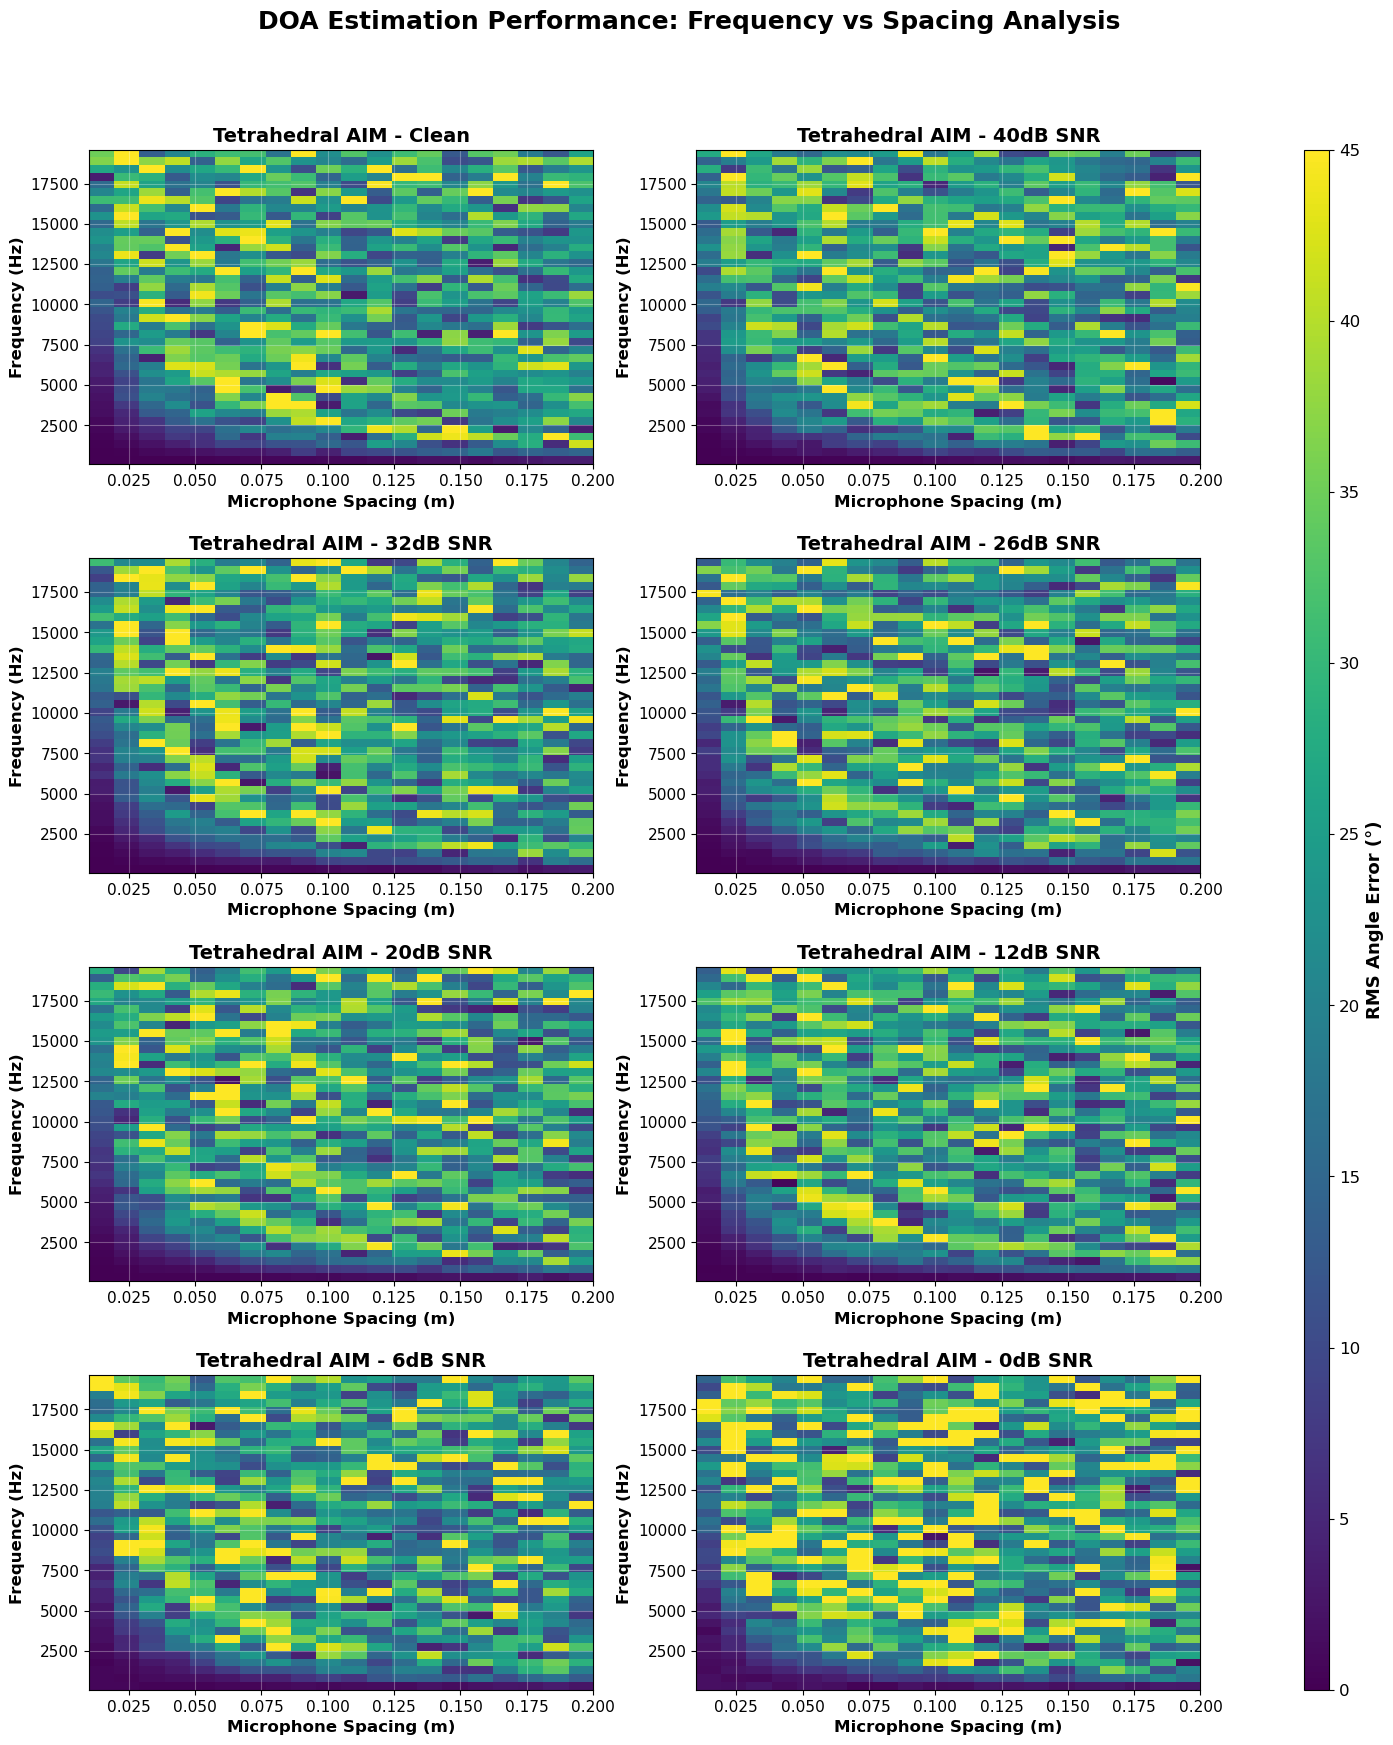

In [ ]:
parameter_sets = [
        
        {
            'mic_geometry': 'tetra',
            'noise': False,
            'noise_amplitude': 0.00,
            'title': 'Tetrahedral AIM - Clean'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.001,
            'title': 'Tetrahedral AIM - 40dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.0025,
            'title': 'Tetrahedral AIM - 32dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.005,
            'title': 'Tetrahedral AIM - 26dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.01,
            'title': 'Tetrahedral AIM - 20dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.025,
            'title': 'Tetrahedral AIM - 12dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.05,
            'title': 'Tetrahedral AIM - 6dB SNR'
        },
        {
            'mic_geometry': 'tetra',
            'noise': True,
            'noise_amplitude': 0.1,
            'title': 'Tetrahedral AIM - 0dB SNR'
        }
    ]
    
    # Run the grid simulation
results = run_frequency_spacing_grid_simulation_aim(
        sample_rate=10000,
        frequencies=frequencies,
        spacings=spacings,
        angle_range=angle_range,
        parameter_sets=parameter_sets,
        vmin=0,
        vmax=45,  # Adjust based on your expected error range
        figsize=(16, 20)
)